# NHL Analytics Analysis

This is a brief analysis of NHL player salaries and some regression modeling using Light GBM as well as statistical analysis using statsmodels.

Since the data set is not a time based series we dont have to worry too much about serial correlation or heteroskedasticity.

The features of the data set are explained on the Kaggle page.


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import os
print(os.listdir("../input"))

['test_salaries.csv', 'train.csv', 'test.csv']


In [2]:
train = pd.read_csv('../input/train.csv', encoding = "ISO-8859-1")
train.head(10)

,Salary,Born,City,Pr/St,Cntry,Nat,Ht,Wt,DftYr,DftRd,Ovrl,Hand,Last Name,First Name,Position,Team,GP,G,A,A1,A2,PTS,+/-,E+/-,PIM,Shifts,TOI,TOIX,TOI/GP,TOI/GP.1,TOI%,IPP%,SH%,SV%,PDO,F/60,A/60,Pct%,Diff,Diff/60,...,Min,Maj,Match,Misc,Game,CF,CA,FF,FA,SF,SA,xGF,xGA,SCF,SCA,GF,GA,RBF,RBA,RSF,RSA,DSF,DSA,FOW,FOL,HF,HA,GVA,TKA,PENT,PEND,OPS,DPS,PS,OTOI,Grit,DAP,Pace,GS,GS/G
0,925000,97-01-30,Sainte-Marie,QC,CAN,CAN,74,190,2015.0,1.0,18.0,L,Chabot,Thomas,D,OTT,1,0,0,0,0,0,-2,0.0,0,13,429,7.2,7.15,7.16,15.2,0.0,0.0,0.750,750.0,0.00,16.74,0.0,-2,-16.74,...,0,0,0,0,0,9.0,12.0,8.0,10.0,5.0,8.0,0.5,0.9,2.0,3.0,0.0,2.0,1.0,1.0,0.0,1.0,1,2,4.0,5.0,1.0,2.0,1.0,1.0,1.0,1.0,0.0,-0.2,-0.2,40.03,1,0.0,175.7,-0.4,-0.38
1,2250000,93-12-21,Ottawa,ON,CAN,CAN,74,207,2012.0,1.0,15.0,R,Ceci,Cody,D,OTT,79,2,15,6,9,17,-11,-10.4,20,2418,109992,1826.2,23.20,23.17,39.0,30.4,7.4,0.915,989.0,1.84,2.79,39.7,-29,-0.95,...,10,0,0,0,0,1433.0,1992.0,1038.0,1423.0,757.0,997.0,62.0,88.8,197.0,280.0,56.0,85.0,68.0,82.0,79.0,94.0,147,176,949.0,939.0,749.0,671.0,284.0,197.0,104.0,98.0,-0.2,3.4,3.2,2850.59,290,13.3,112.5,14.1,0.18
2,8000000,88-04-16,St. Paul,MN,USA,USA,72,218,2006.0,1.0,7.0,R,Okposo,Kyle,RW,BUF,65,19,26,13,13,45,-7,-1.4,24,1443,73983,1229.2,18.97,18.95,33.1,63.4,9.7,0.934,1031.0,3.47,1.95,64.0,31,1.51,...,12,0,0,0,0,1301.0,1051.0,986.0,826.0,734.0,606.0,70.8,46.4,235.0,133.0,71.0,40.0,60.0,34.0,76.0,52.0,136,86,739.0,600.0,340.0,351.0,168.0,129.0,56.0,70.0,3.7,1.3,5.0,2486.75,102,6.6,114.8,36.8,0.57
3,3500000,92-01-07,Ottawa,ON,CAN,CAN,77,220,2010.0,1.0,3.0,R,Gudbranson,Erik,D,VAN,30,1,5,5,0,6,-14,-5.3,18,765,36603,607.9,20.33,20.31,36.1,37.5,6.2,0.897,959.0,1.58,3.45,31.4,-19,-1.88,...,4,2,0,0,0,460.0,605.0,339.0,467.0,259.0,340.0,22.0,33.6,80.0,130.0,16.0,35.0,27.0,20.0,29.0,32.0,56,52,324.0,328.0,198.0,197.0,86.0,59.0,26.0,22.0,0.0,0.4,0.5,1074.41,130,17.5,105.1,5.9,0.20
4,1750000,94-03-29,Toronto,ON,CAN,CAN,76,217,2012.0,1.0,16.0,R,Wilson,Tom,RW,WSH,82,7,12,4,8,19,9,4.1,133,1453,63592,1059.7,12.93,12.93,23.5,61.3,7.8,0.917,995.0,1.76,2.32,43.1,-10,-0.57,...,33,9,0,1,1,766.0,992.0,546.0,720.0,398.0,495.0,33.5,47.5,124.0,159.0,31.0,41.0,30.0,37.0,43.0,53.0,73,90,528.0,490.0,512.0,422.0,157.0,126.0,88.0,68.0,-0.1,1.4,1.3,3459.09,425,8.3,99.5,21.8,0.27
5,1500000,79-05-23,Strathroy,ON,CAN,CAN,70,192,1997.0,6.0,156.0,L,Campbell,Brian,D,CHI,80,5,12,6,6,17,12,0.7,24,1896,88462,1473.7,18.43,18.43,32.4,23.9,9.8,0.936,1033.0,2.89,1.91,60.2,24,0.98,...,12,0,0,0,0,1356.0,1281.0,971.0,972.0,728.0,730.0,62.9,59.9,210.0,197.0,71.0,47.0,30.0,56.0,58.0,85.0,88,141,570.0,667.0,348.0,707.0,223.0,168.0,76.0,60.0,0.6,3.7,4.3,3069.81,150,4.5,107.4,20.8,0.26
6,950000,90-11-21,Stockholm,NaN,SWE,SWE,71,185,2009.0,2.0,53.0,L,Rodin,Anton,RW,VAN,3,0,1,0,1,1,1,0.3,0,40,1604,26.7,8.92,8.91,19.1,100.0,14.3,1.000,1143.0,2.24,0.00,100.0,1,2.24,...,0,0,0,0,0,17.0,23.0,10.0,15.0,7.0,11.0,0.7,0.5,3.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,2,0,16.0,13.0,1.0,12.0,3.0,4.0,0.0,1.0,0.0,0.1,0.1,113.46,1,0.0,89.8,0.6,0.18
7,842500,93-07-28,Toronto,ON,CAN,CAN,70,183,NaN,NaN,NaN,R,Rodrigues,Evan,LW/C,BUF,30,4,2,2,0,6,-7,-4.1,4,506,23265,388.2,12.93,12.93,23.5,75.0,4.7,0.925,972.0,1.24,2.63,32.0,-9,-1.39,...,2,0,0,0,0,309.0,379.0,246.0,291.0,170.0,226.0,10.5,17.2,36.0,54.0,8.0,17.0,3.0,13.0,12.0,14.0,15,27,141.0,174.0,192.0,136.0,50.0,30.0,22.0,15.0,0.0,0.2,0.2,1261.25,28,12.0,106.3,6.2,0.21
8,1250000,92-06-14,Scarborough,ON,CAN,CAN,72,214,2010.0,2.0,42.0,R,Smith-Pelly,Devante,RW/C/LW,N.J,53,4,5,2,3,9,-19,-7.9,12,975,42950,717.7,13.57,13.54,24.2,81.8,4.0,0.924,964.0,0.92,2.42,27.5,-18,-1.50,...,6,0,0,0,0,484.0,724.0,380.0,548.0,277.0,384.0,23.8,33.7,74.0,105.0,11.0,29.0,11.0,17.0,13.0,36.0,24,53,286.0,330.0,292.0,240.0,85.0,69.0,47.0,40.0,-0.6,0.3,-0.3,2250.18,138,18.5,101.0,2.0,0.04
9,925000,93-04-27,Petawawa,ON,CAN,CAN,68,178,2011.0,7.0,201.0,L,Peca,Matthew,C,T.B,10,1,1,1,0,2,-3,-2.6,2,159,6867,114.3,11.45,11.44,23.4,100.0,4.4,0.907,952.0,1.05,2.63,28.6,-3,-1.58,...,1,0,0,0,0,103.0,91.0,66.0,73.0,45.0,54

## Clean Up

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Columns: 154 entries, Salary to GS/G
dtypes: float64(73), int64(71), object(10)
memory usage: 736.4+ KB


So there is 73 float features, 71 int, and 10 objects.

In [4]:
obj_cols = train.select_dtypes('object')
obj_cols.head()

,Born,City,Pr/St,Cntry,Nat,Hand,Last Name,First Name,Position,Team
0,97-01-30,Sainte-Marie,QC,CAN,CAN,L,Chabot,Thomas,D,OTT
1,93-12-21,Ottawa,ON,CAN,CAN,R,Ceci,Cody,D,OTT
2,88-04-16,St. Paul,MN,USA,USA,R,Okposo,Kyle,RW,BUF
3,92-01-07,Ottawa,ON,CAN,CAN,R,Gudbranson,Erik,D,VAN
4,94-03-29,Toronto,ON,CAN,CAN,R,Wilson,Tom,RW,WSH


It looks like these are mostly straight forward and we will dig into them in a second but lets take care of the **Born** column.

In [5]:
obj_cols.drop('Born',axis=1,inplace=True)
train['Born'] = pd.to_datetime(train.Born)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [6]:
train.Born.head()

0   1997-01-30
1   1993-12-21
2   1988-04-16
3   1992-01-07
4   1994-03-29
Name: Born, dtype: datetime64[ns]

Now its into date time format and out of the object cols.

In [7]:
for c in obj_cols.columns:
    print('Obj Col: ', c, '   Number of Unqiue Values ->', len(obj_cols[c].value_counts()))

Obj Col:  City    Number of Unqiue Values -> 373
Obj Col:  Pr/St    Number of Unqiue Values -> 37
Obj Col:  Cntry    Number of Unqiue Values -> 18
Obj Col:  Nat    Number of Unqiue Values -> 16
Obj Col:  Hand    Number of Unqiue Values -> 2
Obj Col:  Last Name    Number of Unqiue Values -> 573
Obj Col:  First Name    Number of Unqiue Values -> 308
Obj Col:  Position    Number of Unqiue Values -> 18
Obj Col:  Team    Number of Unqiue Values -> 68


In [8]:
373+37+18+16+2+573+308+18+68

1413

If we dummied this out, we would get approximately an addition 1413 columns, minus the original 9.

We probably wouldnt need the first names though. It would be more interesting to keep the last names given some of hockey's family tradition.

There is something strange about the team category though since there is apparently 68 unique values...and currently only 31 hockey teams.

## A Little Exploration

Lets take a look at the distribution of hockey players Countries relative to this data set.

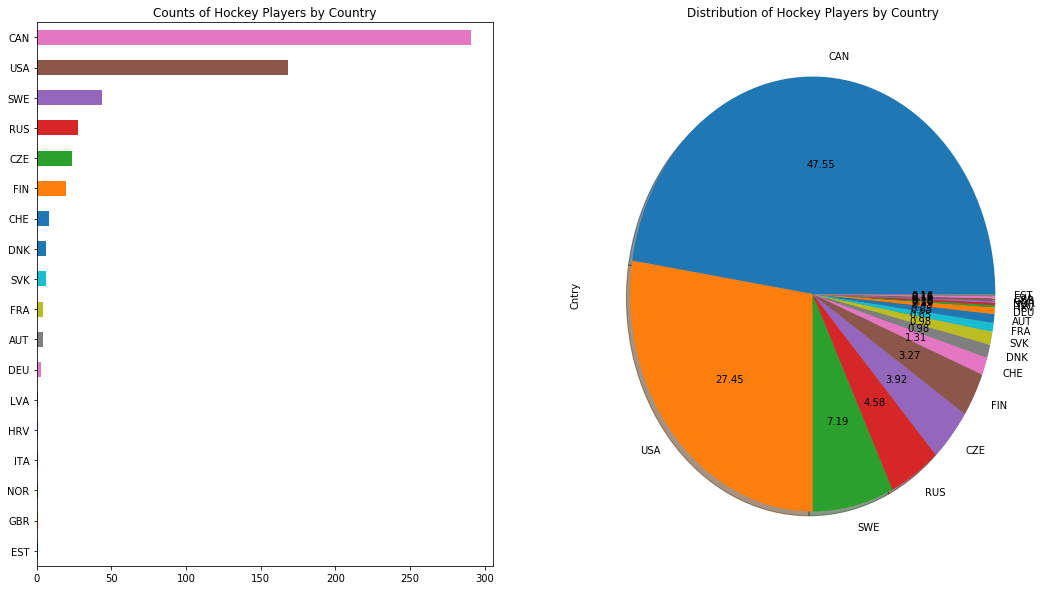

In [9]:
fig, ax=plt.subplots(1,2,figsize=(18,10))
obj_cols['Cntry'].value_counts().sort_values().plot(kind='barh',ax=ax[0]) 
ax[0].set_title("Counts of Hockey Players by Country");
obj_cols['Cntry'].value_counts().plot(kind='pie', autopct='%.2f', shadow=True,ax=ax[1]);
ax[1].set_title("Distribution of Hockey Players by Country");


Canada, USA, Sweden, Russia, Czekoslovakia, Finlad, etc.

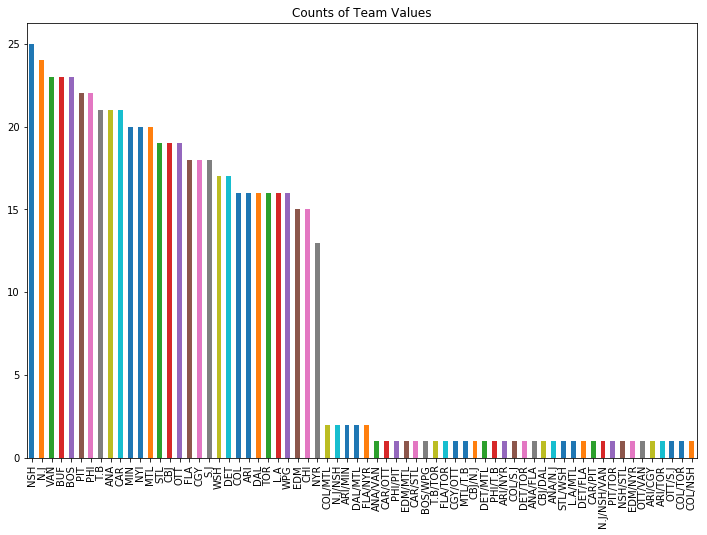

In [10]:
fig, ax=plt.subplots(1,1,figsize=(12,8))
obj_cols['Team'].value_counts().plot(kind='bar',ax=ax);
plt.title('Counts of Team Values');

So now we see what going on with the team values, there are actually some players who split teams so these are accounted for in this data set as well.

## Salary

Lets take a gander at whats going on with our target.

In [11]:
train.Salary.head(10)

0     925000
1    2250000
2    8000000
3    3500000
4    1750000
5    1500000
6     950000
7     842500
8    1250000
9     925000
Name: Salary, dtype: int64

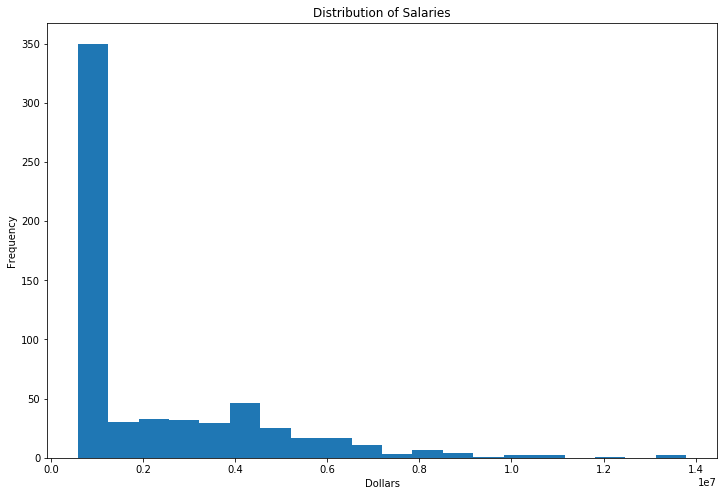

In [12]:
fig, ax=plt.subplots(1,1,figsize=(12,8))
train.Salary.plot(kind='hist',ax=ax, bins=20);
plt.title("Distribution of Salaries");
plt.xlabel('Dollars');

There are a lot of salalries less than a million.

This will very likely skew our data when we try to model it.

Lets take a look at salaries above a million.

In [13]:
sal_gtmil = train[train.Salary >= 1e7]

In [14]:
sal_gtmil.head(10)

,Salary,Born,City,Pr/St,Cntry,Nat,Ht,Wt,DftYr,DftRd,Ovrl,Hand,Last Name,First Name,Position,Team,GP,G,A,A1,A2,PTS,+/-,E+/-,PIM,Shifts,TOI,TOIX,TOI/GP,TOI/GP.1,TOI%,IPP%,SH%,SV%,PDO,F/60,A/60,Pct%,Diff,Diff/60,...,Min,Maj,Match,Misc,Game,CF,CA,FF,FA,SF,SA,xGF,xGA,SCF,SCA,GF,GA,RBF,RBA,RSF,RSA,DSF,DSA,FOW,FOL,HF,HA,GVA,TKA,PENT,PEND,OPS,DPS,PS,OTOI,Grit,DAP,Pace,GS,GS/G
103,13800000,1988-11-19,Buffalo,NY,USA,USA,71,177,2007.0,1.0,1.0,L,Kane,Patrick,RW/C,CHI,82,34,55,36,19,89,11,-6.5,32,1910,105263,1742.9,21.40,21.35,36.3,78.1,11.2,0.918,1030.0,3.92,2.31,63.0,47,1.62,...,16,0,0,0,0,1916.0,1394.0,1389.0,1070.0,1020.0,817.0,91.5,69.2,292.0,237.0,114.0,67.0,46.0,65.0,61.0,96.0,107,161,742.0,816.0,260.0,610.0,283.0,211.0,69.0,91.0,8.7,2.1,10.8,3057.71,75,4.8,114.0,89.2,1.09
145,10900000,1987-08-07,Cole Harbour,NS,CAN,CAN,71,200,2005.0,1.0,1.0,L,Crosby,Sidney,C,PIT,75,44,45,28,17,89,17,18.4,24,1852,89450,1489.6,19.88,19.87,34.1,74.2,11.4,0.917,1031.0,4.83,2.38,67.0,61,2.46,...,12,0,0,0,0,1841.0,1272.0,1393.0,959.0,1056.0,715.0,111.1,65.9,419.0,231.0,120.0,59.0,106.0,58.0,60.0,64.0,166,122,857.0,917.0,482.0,651.0,223.0,160.0,82.0,110.0,10.5,1.7,12.3,2880.93,131,9.9,125.4,94.6,1.26
208,11000000,1989-05-13,Toronto,ON,CAN,CAN,72,210,2007.0,2.0,43.0,R,Subban,P.K.,D,NSH,66,10,30,13,17,40,-8,10.4,44,1860,96640,1603.1,24.40,24.36,40.7,52.6,8.9,0.896,986.0,2.84,2.81,50.3,1,0.04,...,16,2,0,0,0,1602.0,1340.0,1213.0,1032.0,852.0,724.0,75.0,64.9,235.0,211.0,76.0,75.0,58.0,44.0,75.0,60.0,133,104,855.0,795.0,446.0,486.0,218.0,179.0,90.0,99.0,3.6,2.4,6.1,2338.29,228,6.8,110.1,52.8,0.80
226,10000000,1989-08-15,Kladno,NaN,CZE,CZE,74,214,2007.0,1.0,7.0,L,Voracek,Jakub,RW,PHI,82,20,41,26,15,61,-24,-0.8,56,1995,93911,1556.6,19.07,19.05,33.0,68.5,8.9,0.894,983.0,3.43,2.81,54.9,16,0.62,...,13,2,0,1,1,1907.0,1225.0,1419.0,905.0,1000.0,691.0,99.4,56.7,343.0,188.0,89.0,73.0,83.0,52.0,60.0,84.0,143,136,939.0,774.0,478.0,616.0,259.0,124.0,102.0,112.0,4.6,1.0,5.6,3161.36,110,4.2,120.7,60.4,0.74
260,10000000,1985-09-17,Moscow,NaN,RUS,RUS,75,239,2004.0,1.0,1.0,R,Ovechkin,Alex,LW/RW,WSH,82,33,36,20,16,69,6,1.5,50,1737,90361,1501.0,18.37,18.35,32.3,65.1,11.3,0.912,1025.0,4.24,2.28,65.0,49,1.96,...,25,0,0,0,0,1804.0,1251.0,1367.0,949.0,941.0,650.0,92.6,60.4,313.0,214.0,106.0,57.0,61.0,51.0,73.0,83.0,134,134,756.0,784.0,549.0,432.0,261.0,194.0,97.0,72.0,7.0,1.7,8.7,3150.92,295,9.8,122.1,75.6,0.92
496,13800000,1988-04-29,Winnipeg,MB,CAN,CAN,74,201,2006.0,1.0,3.0,L,Toews,Jonathan,C,CHI,72,21,37,21,17,58,7,-7.3,35,1772,87066,1450.1,20.15,20.15,33.6,70.7,10.0,0.911,1011.0,3.39,2.81,54.7,14,0.58,...,15,1,0,0,0,1521.0,1303.0,1087.0,994.0,822.0,763.0,73.8,66.2,241.0,229.0,82.0,68.0,51.0,42.0,42.0,76.0,93,118,860.0,717.0,289.0,554.0,223.0,164.0,70.0,78.0,4.7,1.6,6.3,2866.62,111,5.3,116.8,62.4,0.87
542,12000000,1985-08-14,Sicamous,BC,CAN,CAN,76,232,2003.0,2.0,49.0,R,Weber,Shea,D,MTL,78,17,25,9,16,42,20,6.5,38,2218,117286,1939.4,25.07,25.00,41.3,48.8,9.1,0.933,1025.0,2.66,1.89,58.5,25,0.77,...,19,0,0,0,0,1799.0,1767.0,1318.0,1241.0,941.0,913.0,83.4,79.1,274.0,266.0,86.0,61.0,79.0,55.0,118.0,98.0,197,153,1085.0,1120.0,686.0,797.0,366.0,179.0,122.0,115.0,4.1,6.0,10.1,2759.46,335,7.9,110.3,53.9,0.69


Right here we see some big names in this set. This set also only appears to be 7 items long.

## Model

My thoughts with this are to dummy out most of the objects variables and using light gbm.

In [15]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

We had done some cleaning above but were going to create a function that handles it to work out the test data as well.

Additionally, we found out that the test and train splits arent evenly split so we need to go back and merge the data first.

In [16]:
def data_clean(x):
    ## Were going to change Born to date time
    x['Born'] = pd.to_datetime(x.Born, yearfirst=True)
    x['dowBorn'] = x.Born.dt.dayofweek
    x["doyBorn"] = x.Born.dt.dayofyear
    x["monBorn"] = x.Born.dt.month
    x['yrBorn'] = x.Born.dt.year
    ## Drop Pr/St due to NaNs from other countries and First Name
    x.drop(['Pr/St','First Name'], axis=1, inplace=True)
    ocols = ['City', 'Cntry', 'Nat', 'Last Name', 'Position', 'Team']
    for oc in ocols:
        temp = pd.get_dummies(x[oc])
        x = x.join(temp, rsuffix=str('_'+oc))
    x['Hand'] = pd.factorize(x.Hand)[0]
    x.drop(ocols, axis=1, inplace=True)
    x.drop(['Born'],axis=1,inplace=True)
    return x
    
    

In [17]:
try:
    del train, x0, xc, test
except:
    pass

In [18]:
train = pd.read_csv('../input/train.csv', encoding="ISO-8859-1")
train.head()

,Salary,Born,City,Pr/St,Cntry,Nat,Ht,Wt,DftYr,DftRd,Ovrl,Hand,Last Name,First Name,Position,Team,GP,G,A,A1,A2,PTS,+/-,E+/-,PIM,Shifts,TOI,TOIX,TOI/GP,TOI/GP.1,TOI%,IPP%,SH%,SV%,PDO,F/60,A/60,Pct%,Diff,Diff/60,...,Min,Maj,Match,Misc,Game,CF,CA,FF,FA,SF,SA,xGF,xGA,SCF,SCA,GF,GA,RBF,RBA,RSF,RSA,DSF,DSA,FOW,FOL,HF,HA,GVA,TKA,PENT,PEND,OPS,DPS,PS,OTOI,Grit,DAP,Pace,GS,GS/G
0,925000,97-01-30,Sainte-Marie,QC,CAN,CAN,74,190,2015.0,1.0,18.0,L,Chabot,Thomas,D,OTT,1,0,0,0,0,0,-2,0.0,0,13,429,7.2,7.15,7.16,15.2,0.0,0.0,0.750,750.0,0.00,16.74,0.0,-2,-16.74,...,0,0,0,0,0,9.0,12.0,8.0,10.0,5.0,8.0,0.5,0.9,2.0,3.0,0.0,2.0,1.0,1.0,0.0,1.0,1,2,4.0,5.0,1.0,2.0,1.0,1.0,1.0,1.0,0.0,-0.2,-0.2,40.03,1,0.0,175.7,-0.4,-0.38
1,2250000,93-12-21,Ottawa,ON,CAN,CAN,74,207,2012.0,1.0,15.0,R,Ceci,Cody,D,OTT,79,2,15,6,9,17,-11,-10.4,20,2418,109992,1826.2,23.20,23.17,39.0,30.4,7.4,0.915,989.0,1.84,2.79,39.7,-29,-0.95,...,10,0,0,0,0,1433.0,1992.0,1038.0,1423.0,757.0,997.0,62.0,88.8,197.0,280.0,56.0,85.0,68.0,82.0,79.0,94.0,147,176,949.0,939.0,749.0,671.0,284.0,197.0,104.0,98.0,-0.2,3.4,3.2,2850.59,290,13.3,112.5,14.1,0.18
2,8000000,88-04-16,St. Paul,MN,USA,USA,72,218,2006.0,1.0,7.0,R,Okposo,Kyle,RW,BUF,65,19,26,13,13,45,-7,-1.4,24,1443,73983,1229.2,18.97,18.95,33.1,63.4,9.7,0.934,1031.0,3.47,1.95,64.0,31,1.51,...,12,0,0,0,0,1301.0,1051.0,986.0,826.0,734.0,606.0,70.8,46.4,235.0,133.0,71.0,40.0,60.0,34.0,76.0,52.0,136,86,739.0,600.0,340.0,351.0,168.0,129.0,56.0,70.0,3.7,1.3,5.0,2486.75,102,6.6,114.8,36.8,0.57
3,3500000,92-01-07,Ottawa,ON,CAN,CAN,77,220,2010.0,1.0,3.0,R,Gudbranson,Erik,D,VAN,30,1,5,5,0,6,-14,-5.3,18,765,36603,607.9,20.33,20.31,36.1,37.5,6.2,0.897,959.0,1.58,3.45,31.4,-19,-1.88,...,4,2,0,0,0,460.0,605.0,339.0,467.0,259.0,340.0,22.0,33.6,80.0,130.0,16.0,35.0,27.0,20.0,29.0,32.0,56,52,324.0,328.0,198.0,197.0,86.0,59.0,26.0,22.0,0.0,0.4,0.5,1074.41,130,17.5,105.1,5.9,0.20
4,1750000,94-03-29,Toronto,ON,CAN,CAN,76,217,2012.0,1.0,16.0,R,Wilson,Tom,RW,WSH,82,7,12,4,8,19,9,4.1,133,1453,63592,1059.7,12.93,12.93,23.5,61.3,7.8,0.917,995.0,1.76,2.32,43.1,-10,-0.57,...,33,9,0,1,1,766.0,992.0,546.0,720.0,398.0,495.0,33.5,47.5,124.0,159.0,31.0,41.0,30.0,37.0,43.0,53.0,73,90,528.0,490.0,512.0,422.0,157.0,126.0,88.0,68.0,-0.1,1.4,1.3,3459.09,425,8.3,99.5,21.8,0.27


In [19]:
test = pd.read_csv('../input/test.csv', encoding="ISO-8859-1")
test.head()

,Born,City,Pr/St,Cntry,Nat,Ht,Wt,DftYr,DftRd,Ovrl,Hand,Last Name,First Name,Position,Team,GP,G,A,A1,A2,PTS,+/-,E+/-,PIM,Shifts,TOI,TOIX,TOI/GP,TOI/GP.1,TOI%,IPP%,SH%,SV%,PDO,F/60,A/60,Pct%,Diff,Diff/60,iCF,...,Min,Maj,Match,Misc,Game,CF,CA,FF,FA,SF,SA,xGF,xGA,SCF,SCA,GF,GA,RBF,RBA,RSF,RSA,DSF,DSA,FOW,FOL,HF,HA,GVA,TKA,PENT,PEND,OPS,DPS,PS,OTOI,Grit,DAP,Pace,GS,GS/G
0,88-11-05,Ithaca,NY,USA,USA,72,216,2003.0,1.0,13.0,R,Brown,Dustin,RW/LW,L.A,80,14,22,9,13,36,-4,8.2,22,1729,76801,1278.5,16.00,15.99,27.2,65.5,8.5,0.898,982,2.58,2.77,48.2,-4,-0.19,326.0,...,11,0,0,0,0,1239,1114,927,821,649,577,60.8,52.4,203,184,55,59,62,39,57,73,119,112,639,652,651,542,194,83,72,65,1.9,1.8,3.7,3418.06,243,19.5,110.4,47.3,0.59
1,00-02-29,Prague,NaN,CZE,CZE,72,195,2014.0,1.0,13.0,L,Vrana,Jakub,LW,WSH,21,3,3,2,1,6,2,0.4,2,291,13997,233.2,11.12,11.11,22.0,66.7,6.7,0.969,1037,2.32,0.77,75.0,6,1.54,56.0,...,1,0,0,0,0,282,179,201,132,134,98,14.2,8.0,53,24,9,3,11,8,13,15,24,23,91,85,75,83,42,26,16,10,0.3,0.3,0.6,826.49,15,10.0,118.6,8.9,0.42
2,92-04-24,St. Louis,MO,USA,USA,75,227,2007.0,6.0,161.0,L,Maroon,Patrick,LW,EDM,81,27,15,9,6,42,13,15.0,95,1715,81345,1351.9,16.73,16.72,30.0,54.5,9.5,0.919,1014,3.42,2.09,62.1,30,1.33,300.0,...,25,9,0,0,0,1500,1091,1116,791,809,581,82.0,53.2,322,186,77,47,55,31,65,77,120,108,555,661,511,486,298,184,77,86,3.9,2.0,6.0,3155.13,316,8.9,115.0,52.5,0.65
3,99-07-05,Piikkio,NaN,FIN,FIN,72,182,2013.0,2.0,55.0,L,Lehkonen,Artturi,LW,MTL,73,18,10,3,7,28,-1,3.0,8,1488,60702,1010.0,13.87,13.85,24.9,63.6,8.5,0.922,1007,2.61,2.26,53.7,6,0.36,279.0,...,4,0,0,0,0,1006,877,714,655,518,489,47.2,39.0,163,140,44,38,34,29,72,49,106,78,521,461,399,499,160,95,44,40,2.3,1.1,3.4,3044.03,105,24.3,111.9,38.1,0.52
4,96-10-27,Niagara Falls,NY,USA,USA,72,196,2011.0,2.0,36.0,R,Clendening,Adam,D,NYR,31,2,9,2,7,11,3,3.6,17,658,29406,490.2,15.82,15.81,28.7,47.8,9.3,0.909,1002,2.82,2.08,57.5,6,0.73,89.0,...,6,1,0,0,0,508,353,372,267,247,187,24.2,16.7,77,44,23,17,14,8,19,21,33,29,239,227,175,211,87,60,30,25,0.8,1.1,1.9,1217.17,67,4.8,105.4,15.9,0.51


In [20]:
full = train.merge(test, how='outer')
print(train.shape, test.shape, full.shape)

(612, 154) (262, 153) (874, 154)


In [21]:
y = np.log(full.Salary.dropna())
full0 = full.drop(['Salary'],axis=1)

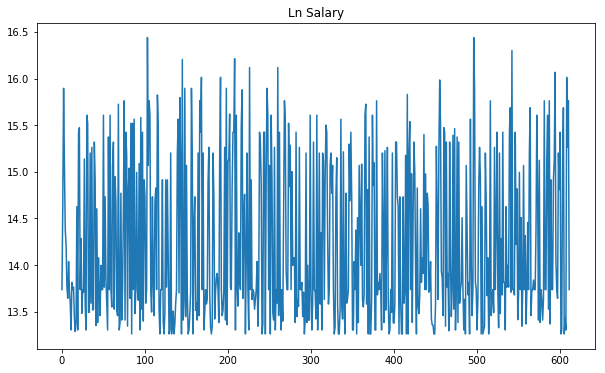

In [22]:
fig, ax=plt.subplots(1,1,figsize=(10,6))
y.plot(ax=ax);
plt.title("Ln Salary");

In [23]:
obj_cols.columns

Index(['City', 'Pr/St', 'Cntry', 'Nat', 'Hand', 'Last Name', 'First Name',
       'Position', 'Team'],
      dtype='object')

In [24]:
full_c = data_clean(full0)

In [25]:
print(full0.shape, full_c.shape)

(874, 155) (874, 1573)


In [26]:
full_c.head()

,Ht,Wt,DftYr,DftRd,Ovrl,Hand,GP,G,A,A1,A2,PTS,+/-,E+/-,PIM,Shifts,TOI,TOIX,TOI/GP,TOI/GP.1,TOI%,IPP%,SH%,SV%,PDO,F/60,A/60,Pct%,Diff,Diff/60,iCF,iCF.1,iFF,iSF,iSF.1,iSF.2,ixG,iSCF,iRB,iRS,...,DET/NYR,DET/TOR,EDM,EDM/MTL,EDM/NYR,FLA,FLA/NYR,FLA/T.B,FLA/TOR,L.A,L.A/MTL,MIN,MTL,MTL/T.B,N.J,N.J/NSH,N.J/NSH/VAN,NSH,NSH/STL,NYI,NYR,NYR/OTT,OTT,OTT/S.J,OTT/VAN,PHI,PHI/PIT,PHI/T.B,PIT,PIT/TOR,S.J,S.J/VAN,STL,STL/WSH,T.B,T.B/TOR,TOR,VAN,WPG,WSH
0,74,190,2015.0,1.0,18.0,0,1,0,0,0,0,0,-2,0.0,0,13,429,7.2,7.15,7.16,15.2,0.0,0.0,0.750,750.0,0.00,16.74,0.0,-2,-16.74,2.0,2,2.0,1.0,1,1,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,74,207,2012.0,1.0,15.0,1,79,2,15,6,9,17,-11,-10.4,20,2418,109992,1826.2,23.20,23.17,39.0,30.4,7.4,0.915,989.0,1.84,2.79,39.7,-29,-0.95,287.0,287,197.0,143.0,143,143,6.1,7.0,7.0,9.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,72,218,2006.0,1.0,7.0,1,65,19,26,13,13,45,-7,-1.4,24,1443,73983,1229.2,18.97,18.95,33.1,63.4,9.7,0.934,1031.0,3.47,1.95,64.0,31,1.51,283.0,283,212.0,155.0,156,156,17.4,64.0,16.0,20.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,77,220,2010.0,1.0,3.0,1,30,1,5,5,0,6,-14,-5.3,18,765,36603,607.9,20.33,20.31,36.1,37.5,6.2,0.897,959.0,1.58,3.45,31.4,-19,-1.88,88.0,88,55.0,40.0,40,40,1.4,2.0,1.0,4.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,76,217,2012.0,1.0,16.0,1,82,7,12,4,8,19,9,4.1,133,1453,63592,1059.7,12.93,12.93,23.5,61.3,7.8,0.917,995.0,1.76,2.32,43.1,-10,-0.57,166.0,166,118.0,95.0,95,95,9.3,35.0,8.0,10.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [27]:
ss = StandardScaler()

In [28]:
full_cs = ss.fit_transform(full_c)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


This cell below splits on the shape indices we have a few cells up.

In [29]:
train_c = full_cs[:612]
test_c = full_cs[612:]

In [30]:
print(train_c.shape, y.shape, test_c.shape)

(612, 1573) (612,) (262, 1573)


In [31]:
type(y)

pandas.core.series.Series

### LGB Model

In [32]:
folds = 3
lgbm_params = {
    "max_depth": -1,
    "num_leaves": 1000,
    "learning_rate": 0.01,
    "n_estimators": 1000,
    "objective":'regression',
    'min_data_in_leaf':64,
    'feature_fraction': 0.8,
    'colsample_bytree':0.8,
    "metric":['mae','mse'],
    "boosting_type": "gbdt",
    "n_jobs": -1,
    "reg_lambda": 0.9,
    "random_state": 123
}
preds = 0
for f in range(folds):
    xt, xv, yt, yv = train_test_split(train_c, y.values, test_size=0.2, random_state=((f+1)*123))
    
    xtd = lgb.Dataset(xt, label=yt)
    xvd = lgb.Dataset(xv, label=yv)
    mod = lgb.train(params=lgbm_params, train_set=xtd, 
                    num_boost_round=1000, valid_sets=xvd, valid_names=['valset'],
                    early_stopping_rounds=20, verbose_eval=20)
    
    preds += mod.predict(test_c)
    
preds = preds/folds
    
    

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds.
[20]	valset's l2: 0.564863	valset's l1: 0.673578
[40]	valset's l2: 0.453872	valset's l1: 0.598066
[60]	valset's l2: 0.380566	valset's l1: 0.540044
[80]	valset's l2: 0.330633	valset's l1: 0.492135
[100]	valset's l2: 0.295675	valset's l1: 0.453573
[120]	valset's l2: 0.271764	valset's l1: 0.425478
[140]	valset's l2: 0.254423	valset's l1: 0.402047
[160]	valset's l2: 0.241881	valset's l1: 0.387692
[180]	valset's l2: 0.231166	valset's l1: 0.376087
[200]	valset's l2: 0.223362	valset's l1: 0.367421
[220]	valset's l2: 0.217925	valset's l1: 0.360755
[240]	valset's l2: 0.214305	valset's l1: 0.355547
[260]	valset's l2: 0.211131	valset's l1: 0.350838
[280]	valset's l2: 0.208286	valset's l1: 0.347377
[300]	valset's l2: 0.206366	valset's l1: 0.344892
[320]	valset's l2: 0.204723	valset's l1: 0.342563
[340]	valset's l2: 0.203764	valset's l1: 0.340609
[360]	valset's l2: 0.203372	valset's l1: 0.339329
[380]	valset's l2: 0.202722	valset's l1: 0

## Actual Test Data

In [33]:
acts = pd.read_csv('../input/test_salaries.csv', encoding="ISO-8859-1")
acts['preds'] = np.exp(preds)
acts.head()

,Salary,preds
0,7000000.0,3.813335e+06
1,925000.0,8.500037e+05
2,2000000.0,3.165594e+06
3,667500.0,1.066605e+06
4,600000.0,8.832996e+05


In [34]:
import matplotlib
from sklearn.metrics import mean_absolute_error, mean_squared_error

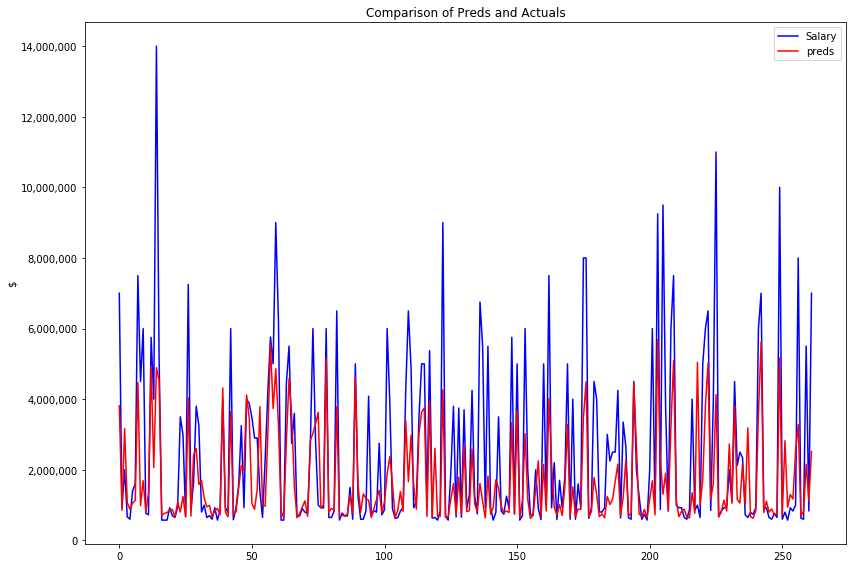

In [35]:
fig, ax=plt.subplots(1,1,figsize=(12,8))
acts.plot(ax=ax, style=['b-','r-']);
plt.title("Comparison of Preds and Actuals");
plt.ylabel('$');
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()

Based on the items above, it appears we missed a lot of the outliers which is something we would need to grab with perhaps a quantile regression.

In [36]:
mse = mean_squared_error(np.log(acts.Salary), np.log(acts.preds))
mae = mean_absolute_error(np.log(acts.Salary), np.log(acts.preds))

In [37]:
print("Ln Level Mean Squared Error :", mse)
print("Ln Level Mean Absolute Error :", mae)

Ln Level Mean Squared Error : 0.32829220938672277
Ln Level Mean Absolute Error : 0.4263148368980229


In [38]:
fi_df = pd.DataFrame( 100*mod.feature_importance()/mod.feature_importance().max(), 
                      index=full_c.columns, #mod.feature_name(),
                      columns =['importance'])

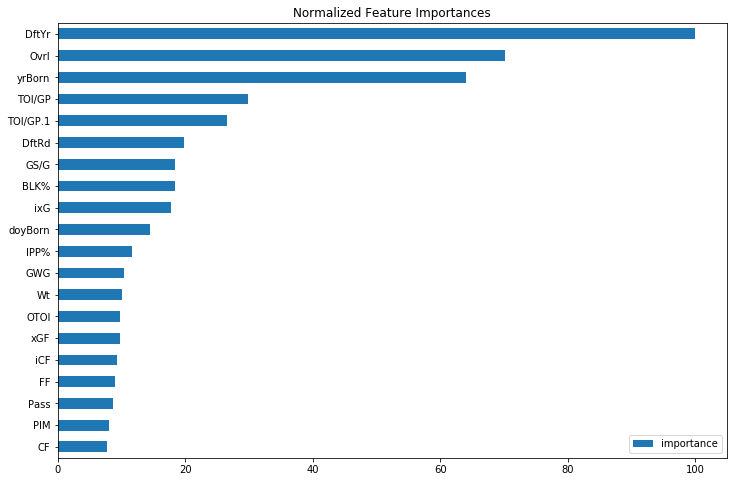

In [39]:
fig, ax=plt.subplots(1,1,figsize=(12,8))
fi_df.sort_values(by='importance',ascending=True).iloc[-20:].plot(kind='barh', color='C0', ax=ax)
plt.title("Normalized Feature Importances");

Top Features are:
- Draft Year
- Where the player was drafted over-all.
- Year Born
- Time On Ice / Games Played
- Time On Ice (TOI/GP.l)
- Draft Round
- PLayers Avg Gane Score
- Percentage of all opposing shot attempts blocked by this player
- Expected goals (weighted shots) for this individual, which is shot attempts weighted by shot location
- Day Of Year Born


Time On Ice per GP doesnt seem so unusual as you would pay the ones who were better more and if theyre better, then they get paid more.

The Percentage of opposing shot attempts blocked is kinda of wild! Selke Trophy much?


In [40]:
import statsmodels.api as sma

For regressions I like to take the top couple effects from the Decision Tree and model it using statsmodels to get a better idea of the stastitical soundness of the model.

In [41]:
top10 = fi_df.sort_values(by='importance',ascending=True).iloc[-10:].index
top10

exog = pd.DataFrame(test_c, columns=full_c.columns)[list(top10)].fillna(0)

In [42]:
ols = sma.OLS(exog=exog, endog=acts.Salary)
ols_fit = ols.fit()
print(ols_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     69.44
Date:                Fri, 15 Mar 2019   Prob (F-statistic):           1.30e-66
Time:                        17:49:11   Log-Likelihood:                -4143.6
No. Observations:                 262   AIC:                             8307.
Df Residuals:                     252   BIC:                             8343.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
doyBorn      2.51e+05   1.17e+05      2.154      0.0

According to the OLS, Draft Round and Block Shot % and Overall draft Position are not that statistically significant for this model.

The model has a good R squared.


In [43]:
ols_preds = ols_fit.predict()

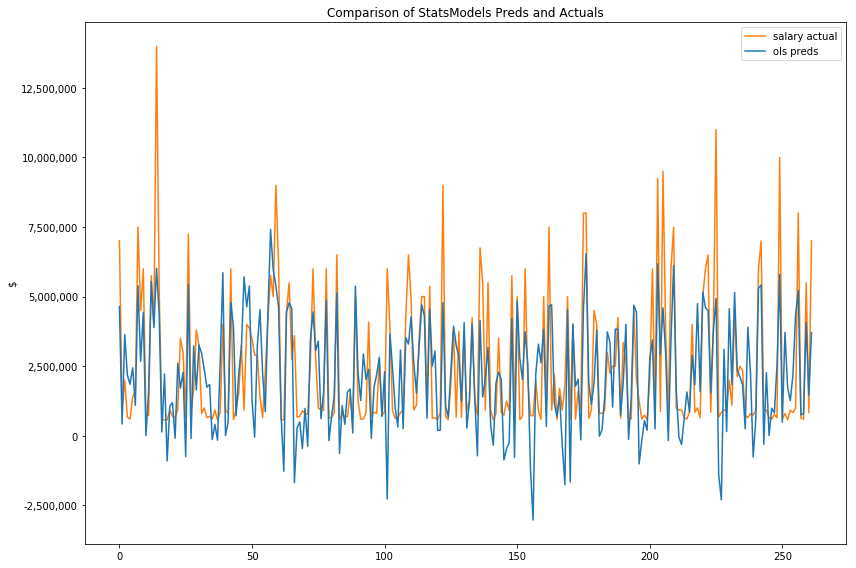

In [44]:
fig, ax=plt.subplots(1,1,figsize=(12,8))
acts.Salary.plot(ax=ax, color='C1');
ax.plot(ols_preds, color='C0');
plt.title("Comparison of StatsModels Preds and Actuals");
plt.ylabel('$');
plt.legend(['salary actual','ols preds']);
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()

In this instance, we were able to predict negative values which doesnt make sense and would have to be cut off at 0.